# Imaging Lab 3: Multipixel Scanning

## EECS 16A: Designing Information Devices and Systems I, Fall 2020


## Table of Contents

* [Instructions](#instructions)
* [Lab Policies](#policies)
* [Overview](#overview)
* [Task 1: Generating Multipixel Scanning Matrices](#matrixGenIntro)
    * [Task 1a: Imaging Mask Matrix Practice](#simpleMatrixGen)
    * [Task 1b: Generating a Random Binary Mask Matrix](#randomBinaryMatrixGen)
* [Task 2: Imaging Simulator](#simulatorIntro)
    * [Task 2a: Constructing an Ideal Sensor Model](#idealSensor)
    * [Task 2b: Image Reconstruction Using the Ideal Sensor Model + Matrix Inverse](#idealReconstruction)
    * [Task 2c: Handling System Non-Idealities](#nonidealities)
        * [Noise *(Why So Grainy? ☹)*](#noiseSimulation)
    * [Task 2d: Eigenanalysis & the Robustness of Inverse-Based Reconstruction](#eigenanalysis)
        * [Graphical Interpretation](#graphicalInterpretation)
        * [Revisiting the Identity Matrix](#revisitingIdentity)
        * [Comparing Scanning Matrices](#comparingScanning)
* [Task 3: Scanning Images](#scanningImages)
    * [Task 3a: Software Setup](#softSetup)
    * [Task 3b: Single Pixel Sanity Check](#singlePixel)
    * [Task 3c: Real Multipixel Imaging](#realImaging)
* [Checkoff](#checkoff)

<a id='instructions'></a>
# <span style='color:blue'>Instructions</span>
* Complete this lab by filling in all of the required sections, marked with `"YOUR CODE HERE"` or `"YOUR COMMENTS HERE"`.


* When you finish, submit a checkoff request to get checked off for this lab. Make sure to keep your setup ready to demo and be prepared to answer a few questions to show your understanding of each section.


* Labs will be graded based on completion for teams of 2-4 students.

<a id='policies'></a>
# <span style='color:blue'>Lab Policies</span>
* **YOU MUST ATTEND THE LAB SECTION YOU ARE ENROLLED IN. If you anticipate missing a section, please notify your GSI in advance.**
* **You are free to stay for the full allotted time and hack around with the lab setup or code, but please reserve the GSI's time for lab-related questions.**
* **Keep food and drinks away from your devices / equipment.**

<a id='overview'></a>
# <span style='color:blue'>Overview</span>

Recall that in the last lab, you illuminated one pixel of the image at a time. This week, you'll flex your linear algebra skills and try something different. You will experiment with imaging methods that illuminate *multiple pixels* at a time. You'll find that if we design our masks in a clever way, our imaging system can be much more robust to noise than the single-pixel approach. You will generate a binary mask matrix that the virtual projector will use to illuminate multi-pixel patterns onto your image. Before scanning your custom images, you'll walk through a basic multi-pixel imaging simulation to understand how it works, delve deeper into the differences between ideal and non-ideal imaging, and understand why certain matrices are better than others at imaging in noisy systems.

*Note: A lot of the code to complete this lab will be provided for you to run. However, looking over the code to try to understand what it does is **highly encouraged**. Additionally, we will be writing **functions** to enable multiple parts of this lab to reuse the same code with minimal copy + pasting.*

**<span style = "color: red">Run the following code block to get access to several pre-written functions and helper libraries.</span>**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%run scripts/helpers.py
%matplotlib inline

# <a id = 'matrixGenIntro'><span style = "color: blue">Task 1: Generating Multipixel Scanning Matrices</span></a>

**Note: This lab will use 0 indexing, as it makes the most sense in Python.**

Recall that we can define our imaging system by the following mathematical model:

$$ H \vec{i} = \vec{s} $$ 

$H$ is the imaging mask matrix, $\vec{i}$ is our image in column vector form, and $\vec{s}$ is the sensor output also in column vector form.

In Imaging 2, we scanned our image by highlighting one pixel at a time in a mask. Each row $H_k$ of $H$ defined a 1-D representation of each mask. This meant that scanning an image with $n$ pixels would require an $H$ with $n$ rows. Since we project one mask at a time onto our image, we would need to do exactly $n$ scans. Take a $2\times2$ image for example: $H$ would need exactly 4 rows, and we would make 4 scans.

Let's try something different. We'll still do $n$ scans of our image, but let's try to highlight more than one pixel per mask. We still want to be able to reconstruct our image from our sensor values. So the question is: how do you choose which pixels to illuminate with each mask?

Begin by assigning each pixel value in the 2x2 image to a variable, $p_{ij}$, where $i$ is the row and $j$ is the column associated with the pixel location. <br/><br/>

<center>
    <b>2x2 Image</b>
<img src="images/img_4x4_new.png" align="center" style="height:200px" />
</center>

<!--
In matrix form, the 2x2 image will look like this:
$$\begin{bmatrix} p_{00} & p_{01} \\ p_{10} & p_{11} \end{bmatrix}$$
-->

In our mathematical model above, we represent the 2x2 image as the 1D column vector: 

$$\vec{i} = \begin{bmatrix} p_{00} \\ p_{01} \\ p_{10} \\ p_{11} \end{bmatrix}$$

Likewise, the sensor reading column vector is represented as:

$$\vec{s} = \begin{bmatrix} s_0 \\ s_1 \\ s_2 \\ s_3 \end{bmatrix}$$

Where the sensor reading from the $k$th mask is $s_k$. In the example above, the sensor reading from the 2nd mask is $s_2$. (We consider $s_0$ to be the 0th mask.)

To illustrate the relationship between the mask matrix $H$ (with per-row imaging masks $H_k$), the image vector $\vec{i}$, and the sensor reading vector $\vec{s}$, we provide you with this **Example System of Linear Equations:**

$$
\begin{align} 
s_0 & = p_{00}\\
s_1 & = p_{00} + p_{01}\\
s_2 & = p_{00} + p_{10}\\
s_3 & = p_{01} + p_{10} + p_{11}
\end{align}
$$

**<span style = "color: red">*IMPORTANT*: The above system of equations is only an example! It only serves an illustrative purpose for this section of the lab. Please do not use it for the rest of the lab.</span>**

How would you represent the above as a mask matrix $H$? Convince yourself that the image below does just that (where a **white pixel** represents a value of **1** and a **black pixel** represents a value of **0**).</font><br/><br/>

<center>
    <b>Imaging Mask Matrix $H$ for the Example System of Linear Equations</b>
<img src="images/mask_sample_4x4.png" align="center" style="height:200px" />
</center>

Recall that each row of our mask matrix represents a mask in 1-D form. We must *reshape* each row $H_k$ of $H$ into the 2-D mask (Mask $k$) itself before projecting it onto the image. To make sense of the $H$ matrix, it is helpful to look at each mask individually. Let's consider $H_0$, the 0th row of $H$. When we reshape the 1-D $1\times4$ row into a $2\times2$ mask, we get Mask 0 (below on the left). <br/><br/>

<center>
    <b>Individual Masks for the Example System of Linear Equations</b>
<img src="images/H_4x4_split.png" align="center" style="height:200px" />
</center>

Now we can see that 

$$H_k \vec{i} = s_k$$ 

represents one of the equations in our system. 

For example, the equation for $s_0$ only depends on one pixel, $p_{00}$, i.e. the top-left pixel of our $2\times2$ image. We can represent it algebraically as:
    
$$s_0 = H_0 \vec{i}$$

where $H_0 = \begin{bmatrix} 1 & 0 & 0 & 0 \end{bmatrix}$.

So numerically, we can represent the equation as:

$$s_0 = \begin{bmatrix} 1 & 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} p_{00} \\ p_{01} \\ p_{10} \\ p_{11} \end{bmatrix}$$

## <a id = 'simpleMatrixGen'><span style = "color: blue">Task 1a: Imaging Mask Matrix Practice</span></a>

Now that we have an understanding of how to approach multipixel scanning, let's test our approach on a new system of equations:

<center>
<b>Lab 3 System of Equations</b>
$$
\begin{align}
s_0 & = p_{00} + p_{01} + p_{10}\\
s_1 & = p_{00} + p_{11}\\
s_2 & = p_{01} + p_{11}\\
s_3 & = p_{10} + p_{11}
\end{align}
$$

**<span style="color: red">For a 2x2 image represented by $\vec{i}$, create the matrix `H` such that $ H \vec{i} = \vec{s} $ represents the `Lab 3 System of Equations` above.</span>**

Text(0.5, 1.0, '4x4 H')

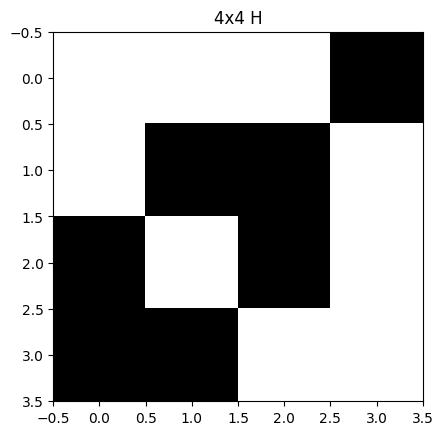

In [2]:
# TODO: Create H (4x4) for the Lab 3 System of Equations --------------------
H_new = np.matrix(
    [[1, 1, 1, 0], [1, 0, 0, 1], [0, 1, 0, 1], [0, 0, 1, 1]]
)  # YOUR CODE HERE

# Show H
plt.imshow(H_new, cmap="gray", interpolation="nearest")
plt.title("4x4 H")

As stated above, we will *reshape* rows $H_k$ of the mask matrix, $H$, into the individual masks themselves. 

**<span style="color: red">You will help to write a function `showMasks` that enables you to iterate through the 4 individual masks and display them as 2x2 images (1 TODO). Double check that the generated masks make sense visually and have the expected number of illuminated pixels. The `showMasks` function will be reused later.</span>**

*Hint: Reference your code from the part of Imaging 2 where you checked to make sure that the scanning matrix was producing the correct pattern by displaying each of the individual masks. You might want to check out the command `np.reshape`.* 

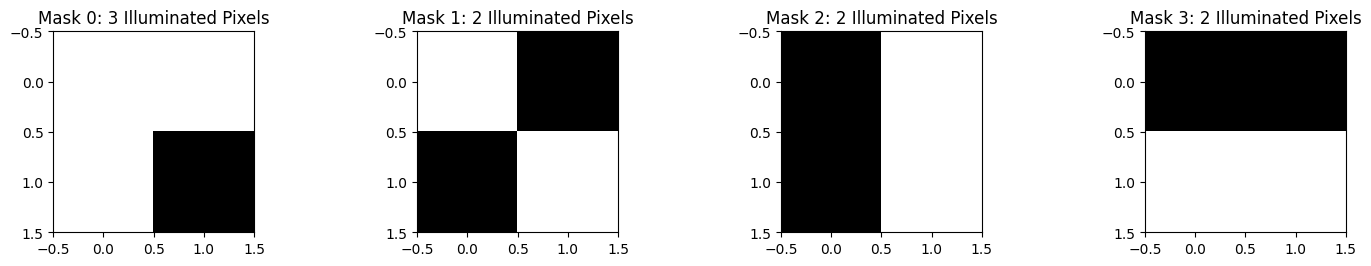

In [3]:
# Inputs
#  `H`: Mask matrix
#  `X`: Image width
#  `Y`: Image height
#  `numMasksShown`: Number of individual masks to display (starting from `H` row 0)
def showMasks(H, X, Y, numMasksShown):
    plt.figure(figsize=(18, 12))
    # Use this for loop to iterate through the first `numMasksShown` rows of `H`
    # you want to display.
    for k in range(numMasksShown):
        plt.subplot(numMasksShown, numMasksShown, k + 1)

        # TODO: Reshape the `k`th row of `H` to be shown in 2D --------------------
        # Hint: `X` is the width of the image you want to observe; `Y` is its height
        mask = np.reshape(H[k], (X, Y))  # YOUR CODE HERE

        plt.imshow(mask, cmap="gray", interpolation="nearest")
        # Title also prints number of illuminated (white) pixels per mask
        plt.title("Mask " + str(k) + ": " + str(np.sum(H[k])) + " Illuminated Pixels")
    plt.show()


# Show individual masks
showMasks(H=H_new, X=2, Y=2, numMasksShown=4)

## <a id = 'randomBinaryMatrixGen'><span style = "color: blue">Task 1b: Generating a Random Binary Mask Matrix</span></a>

A 2x2 image is not very interesting to scan, so we will instead try to scan a 32x32 region. Note that this image has different dimensions compared to last week's image!

**<span style="color: red">To scan a 32x32 image, what dimensions must our scanning matrix $H$ have? What does the number of rows of $H$ correspond to? What does the number of columns correspond to? What do the elements in each column of $H$ represent?</span>**

**<span style = "color: red">`32^2 by 32^2`</span>**

Since we'd like to use a sufficiently interesting set of masks and you *really* don't want to be constructing such a large matrix by hand, we will provide you with a function that generates a random binary mask matrix $H$ for you, given dimensions `(X, Y)` corresponding to your image's width/height, and, as we'll go into later, a parameter for the average number of illuminated pixels per scan. The resulting matrix $H$ will consist entirely of 0's and 1's, where 1's are randomly interspersed among 0's, and each row will contain approximately **`avg1sPerRow`** (see function arguments) # of 1's. Not all rows will contain the same number of 1's!

**<span style="color: red">Run the `generateRandomBinaryMask` function and visually inspect that the generated `randomH` (with approximately 300 pixels illuminated per scan) has the right dimensions & visually looks random. Don't worry too much about how this function is actually implemented, but you can check out the code in `scripts/helpers.py`.</span>** 

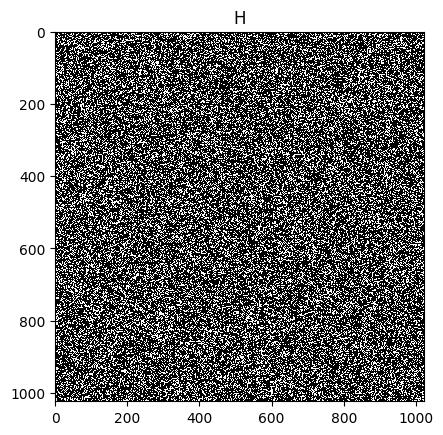

In [4]:
# Generate the randomH mask
randomH = generateRandomBinaryMask(avg1sPerRow=300)

**<span style="color: red">Use the `showMasks` function created earlier to show the first 4 individual masks (rows 0 to 3 of `randomH`) as 32x32 images.</span>**

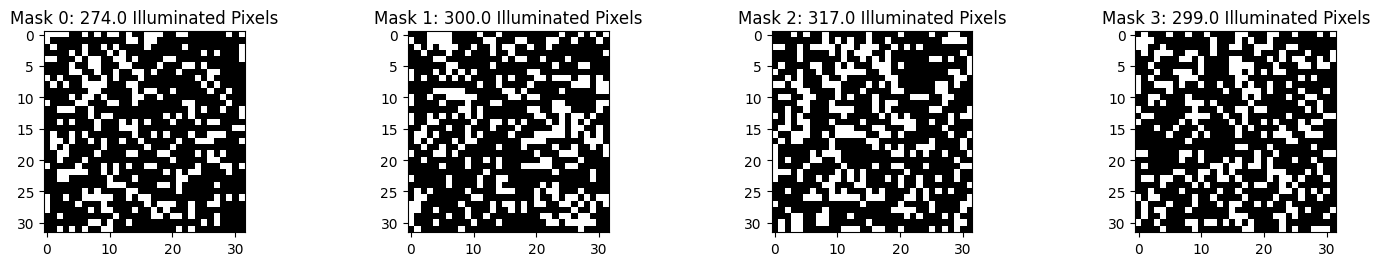

In [5]:
# TODO: Reuse the `showMasks` function from earlier to display the first 4 masks of randomH. -------

# YOUR CODE HERE
showMasks(H=randomH, X=32, Y=32, numMasksShown=4)

Think back to the representation of the imaging system as taking a matrix-vector product. Recall that in the Imaging 2 lab, you reconstructed the image column vector $\vec{i}$ from the sensor reading vector $\vec{s}$ by applying the equation:

$$\vec{i} = H^{-1} \vec{s}$$

You used the **identity** matrix for $H$, for which the inverse $H^{-1}$ exists. In order to apply the same reconstruction method assuming a randomly generated binary $H$, you first need to make sure that your $H$ is actually invertible. 

**<span style="color: red">How can you use Gaussian elimination to check that the square matrix $H$ is invertible? What must be true about the rows of $H$ for it to be invertible?</span>**

**<span style = "color: red">`Use Gaussian elimination. Rows of H must be linearly independent`</span>** 

**Note on invertibility**

Luckily, randomly generated binary matrices are *usually* invertible. However, the function we provided still double checks that the generated $H$ is indeed invertible (using an alternative method to Guassian elimination), and re-generates the matrix if it's not.

# <a id = 'simulatorIntro'><span style = "color: blue">Task 2: Imaging Simulator</span></a>

Let's pause for a minute before we start capturing images with the virtual projector. Recall from Imaging 2 that the real-world projector setup is usually placed inside a cardboard box to prevent light from the outside world disturbing our sensor. Even when the projector is turned off, there might be a significant amount of light inside the box. The sensor and related circuits also generate noise in our measurements due to thermal physics. Thus, non-idealities like noise will inevitably be present in our setup. This is a limitation of the real-world projector that greatly affects our ability to reconstruct the image using the light sensor data.. That's why it's important to build a simulator that **accurately models** what happens when we try to capture an image, including non-idealities that we can potentially compensate for.

Our virtual simulated projector will artificially generate noise to affect sensor results in a way that mirrors this real-world phenomenon.

## <a id = 'idealSensor'><span style = "color: blue">Task 2b: Constructing an Ideal Sensor Model</span></a>

Let's first construct a function that emulates what we would *hope* occurs when we scan the image (ideal imaging). An image (represented as the column vector $\vec{i}$) is placed in a region that can be illuminated by the virtual projector. The virtual projector projects a sequence of masks $H_k$ onto the image (illuminating certain pixels at a time). In our simulation, the digitized 'light sensor' output is the sum of the brightnesses detected across illuminated pixels. The $k^{th}$ entry of the sensor output vector, $s_k$, corresponds to the $k^{th}$ scan.

Recall that these operations can be represented by the previously defined mathematical model:

$$\vec{s} = H \vec{i}$$ 

**<span style="color:red"> Your first goal is to translate this ideal model into a `simulateIdealCapture` function (Fill in the TODO). Apply the function using the supplied 32x32 image of a playing card and your generated random binary matrix `H`. Display the simulated sensor readout as a 32x32 image.</span>**

*Hint: Remember to use `np.dot` to do matrix multiplication.*

The card you're trying to image should look like: <br/><br/>

<center>
<img src="images/raw_card.png" align="center" style="height:200px" />
</center>

Think about what the output sensor readings will look like. Given randomly generated masks, would you expect the output sensor readings to be remotely recognizable?

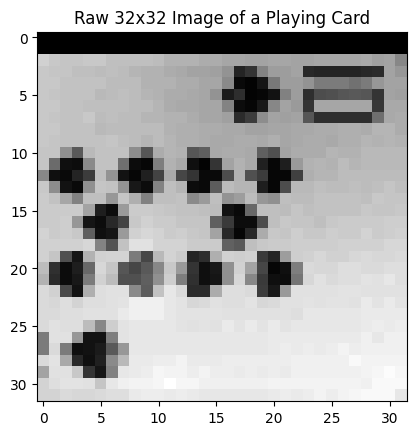

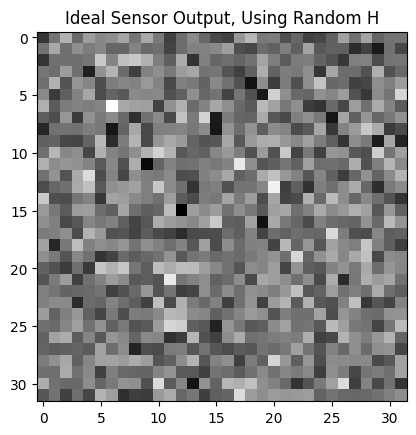

In [6]:
# Inputs:
#  `i2D`: 2D image you're trying to capture
#  `H`: Mask matrix
#  `matrixName`: Name of mask matrix (for image title)
#  `display`: Whether to display the sensor output as a 2D image
# Outputs:
#  `s`: Sensor reading column vector
def simulateIdealCapture(i2D, H, matrixName, display=True):
    # Number of pixels in your image = `iHeight` * `iWidth`
    iHeight = i2D.shape[0]
    iWidth = i2D.shape[1]
    iSize = iHeight * iWidth

    # Convert the 2D image `i2D` into a 1D column vector `i`
    i = np.reshape(i2D, (iSize, 1))  # YOUR CODE HERE

    # TODO: Perform the matrix operation to emulate the ideal imaging system  --------------
    s = np.dot(H, i)  # YOUR CODE HERE

    if display:
        # Reshape the simulated sensor output `s` into an appropriately
        # sized 2D matrix `s2D` and plots it
        s2D = np.reshape(s, (iHeight, iWidth))
        plt.imshow(s2D, cmap="gray", interpolation="nearest")
        plt.title("Ideal Sensor Output, Using %s" % matrixName)
        plt.show()
    return s


# Load card image + display it
i2D = np.load("scripts/raw_card.npy")
plt.imshow(i2D, cmap="gray", interpolation="nearest")
plt.title("Raw 32x32 Image of a Playing Card")
plt.show()

# Simulate the image capture step (ideal)
s = simulateIdealCapture(i2D=i2D, H=randomH, matrixName="Random H");

## <a id = 'idealReconstruction'><span style = "color: blue">Image Reconstruction Using the Ideal Sensor Model + Matrix Inverse</span></a>

As you can see, for *multipixel imaging*, the sensor output does not resemble the original image in any way. By applying the randomly generated mask matrix $H$, you've essentially encrypted the image data, making it unrecognizable to anyone who doesn't know the exact mask matrix $H$ you used (otherwise known as the encryption key).

If you know the key $H$, as stated before, you can reconstruct/decrypt the desired image column vector $\vec{i}$ from the sensor reading vector $\vec{s}$ by essentially *undoing* what the imaging system did to the image and applying the equation:

$$\vec{i} = H^{-1} \vec{s}$$

Again, it's important that we've selected an invertible $H$. 

**<span style="color:red">Now your job is to help write a function `idealReconstruction` (Fill in the TODO) that accepts the column vector $\vec{s}$ and mask matrix $H$ and displays the reconstructed estimate of $\vec{i}$ as a 2D image. Run the reconstruction function using the previously computed `s` and mask matrix `H` and verify that it worked as you expected.</span>**

*Hint: Use `np.linalg.inv` to invert a matrix.*

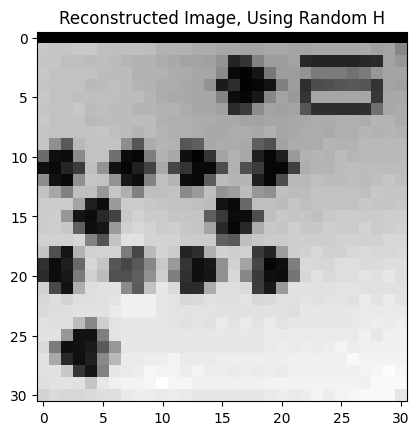

In [7]:
# Inputs
#  `H`: Mask matrix
#  `matrixName`: Name of mask matrix (for image title)
#  `s`: Sensor reading column vector
#  `X`: Image width
#  `Y`: Image height
def idealReconstruction(H, matrixName, s, X=32, Y=32, realImaging=False):
    # TODO: Perform the matrix operations required for reconstruction --------------------
    i = np.dot(np.linalg.inv(H), s)  # YOUR CODE HERE

    if realImaging:
        i = noiseMassage(i, H)

    # Reshape the column vector `i` to display it as a 2D image
    i2D = np.reshape(i, (X, Y))  # YOUR CODE HERE

    # We're going to exclude the top row and left-most column from display
    plt.imshow(i2D[1:, 1:], cmap="gray", interpolation="nearest")
    plt.title("Reconstructed Image, Using %s" % matrixName)
    plt.show()


# Run ideal reconstruction
idealReconstruction(H=randomH, matrixName="Random H", s=s)

## <a id = 'nonidealities'><span style = "color: blue">Task 2c: Handling System Non-Idealities</span></a>

The ideal reconstruction demonstrated above works great, right? Unfortunately, due to real-world non-idealities alluded to earlier, if you directly tried to image a drawing with the multipixel masks in $H$, the reconstruction would probably look terrible. A significant amount of engineering effort is focused on how to best translate theory into practice by attempting to compensate for or remove non-idealities. In the following sections, we'll look at some of the worst offenders and what we can do to improve reconstruction quality. 

### <a id = 'noiseSimulation'><span style = "color: blue">Noise *(Why So Grainy? ☹)*</span></a>

We will see noise again later in Module 3,--if you're really interested in modelling noise and its effects, it's covered more extensively upper division classes including EE123, EE126, EE142 -- but for now it's important to realize that both the light sensor circuit and the projector add noise that shows up in the digitized sensor output. Noise is what causes photos to look grainy or fuzzy. As an example, if your single pixel imaging system from last week happened to be very noisy (and usually, the cheaper the system, the noisier it is...), imaging the card from before might've produced something like: <br/><br/>

<center>
<img src="images/noisy_card.png" align="center" style="height:200px" />
</center>

The noisier your system, the less the resultant image will look like what you expected ☹.

One way to make noise less problematic is to increase the number of pixels illuminated per scan. This increases the "signal level" (i.e. contributions from things we actually care about). At the same time, the amount of noise coming from the light sensor circuit and projector should stay mostly constant, thus improving the so-called *signal-to-noise ratio* (SNR) of our system. This is important to know when choosing `avg1sPerRow` for our random binary mask.

Another way to make noise less problematic is to repeat each scan $k$ (with the same illumination pattern) many times and *average* the sensor outputs. The desired signal is always present, but the *random* error (noise) changes on each repeat scan. Thus, you can "average out the noise" at the expense of spending more time acquiring the image. This is actually what the Launchpad code you will use does under the hood.

Generally speaking, we would like to build a sensing system that is as noise robust as possible, but what does that entail?

## <a id = 'eigenanalysis'><span style = "color: blue">Task 2d: Eigenanalysis $\&$ the Robustness of Inverse-Based Reconstruction</span></a>

## <span style = "color: red">THIS SECTION IS VERY IMPORTANT. PLEASE READ CAREFULLY.</span>
When noise is included, the mathematical model of our imaging system would look like:

$$ \vec{s} = H \vec{i} + \vec{\omega} +\vec{o} $$

The vector $\vec{o}$ is a vector of equal entries, which represents a constant offset from extra light from the projector while it is projecting the color black. Even though black is supposed to be an absence of light, there is still a glow present from the projector that can offset our measurement by a scalar amount. This needs to be removed, but can easily be done so by measuring and subtracting it. 

The elements ($\omega_k$) of the column vector $\vec{\omega}$ correspond to the random amounts of noise added at each measurement $s_k$. We cannot remove noise, but we can try to reduce its effects.

For example, you might expect your sensor readings $\vec{s}$ to be something like 

\begin{equation}
\vec{s_{expected}} = \begin{bmatrix}
51 \\
65 \\
42 \\
\vdots \\
32
\end{bmatrix}
\end{equation}

But you may get something like

\begin{equation}
\vec{s_{reality}} = \begin{bmatrix}
61.2 \\
76.0 \\
51.7 \\
\vdots \\
44.0
\end{bmatrix}\;.
\end{equation}

This means that what you are getting is really

\begin{equation}
    \vec{s_{reality}} = \vec{s_{expected}} \;+\; \vec{\omega} \;+\; \vec{o}
\end{equation}

\begin{equation}
    \begin{bmatrix}
        61.2 \\
        76.0 \\
        51.7 \\
        \vdots \\
        44.0
    \end{bmatrix} = 
    \begin{bmatrix}
        51 \\
        65 \\
        42 \\
        \vdots \\
        32
    \end{bmatrix}
    \;+\;
    \begin{bmatrix}
        0.2 \\
        1.0 \\
        -0.3 \\
        \vdots \\
        2.0
        \end{bmatrix}
    \;+\;
    \begin{bmatrix}
        10 \\
        10 \\
        10 \\
        \vdots \\
        10
    \end{bmatrix}
\end{equation}

where the last two vectors are $\vec{\omega}$ and $\vec{o}$

As you can see, once you measure the offset, it is very easy to just subtract from your measurements. We will take care of this for you in the experimental portion of the lab (below), so you don't need to worry about it. We will ignore it in the rest of the notebook, and assume it is subtracted.

From this point forward, our key equation will look like this:

$$ \vec{s} = H \vec{i} + \vec{\omega}$$

Now we will try to reconstruct the image $\vec{i}$ with matrix inversion $H^{-1}$:

$$ H^{-1}\vec{s} = H^{-1}H \vec{i} + H^{-1}\vec{\omega}$$

$$ H^{-1}\vec{s} = \vec{i} + H^{-1}\vec{\omega}$$

We will call $H^{-1}\vec{s} = \vec{i_{est}}$ leaving us with 
$$ \vec{i_{est}} = H^{-1} \vec{s} = \vec{i} + H^{-1} \vec{\omega} $$

Remember that we were hoping to solve for just $\vec{i}$. The additional undesired term $H^{-1} \vec{\omega}$ is what we call our reconstruction *error*, which results from linearly transforming the original noise vector $\vec{\omega}$ by $H^{-1}$. This implies that our choice of $H$ (and therefore $H^{-1}$) strongly influences how robust our overall imaging system is. 

### To build some intuition on why this is the case, recall that matrix-vector multiplication $A \vec{x} = \vec{b}$ linearly transforms $\vec{x}$ into $\vec{b}$ via scaling and rotation, as designated by $A$. Additionally, recall that the eigenvalues $\lambda_i$ and $n$ length eigenvectors $\vec{v_{\lambda_i}}$ of an $n \times n$ matrix $A$ can be found by solving for:

$$A \vec{v_{\lambda_i}} = \lambda_i \vec{v_{\lambda_i}}$$

Multiplying both sides of this equation by $A^{-1}$ and dividing by $\lambda_i$ allows us to rewrite this equation as:

$$A^{-1} \vec{v_{\lambda_i}} = \frac{1}{\lambda_i} \vec{v_{\lambda_i}} $$ 

How does this help reconstruct our image? We know that $H$, which is an $N \times N$ matrix, is invertible, and thus we know it has at most $N$ linearly independent eigenvectors. 

Our matrix $H$ also has another property, which we haven't learned about yet: it is **diagonalizable**. Diagonalizable matrices are beyond the scope of this course (but covered in EECS16B). For now, all you need to know is that a diagonalizable $N \times N$ matrix $H$ has *precisely* N linearly-independent eigenvectors.
    
So if we know $H$ has N eigenvectors, we know they span $\mathbb{R}^N$. In other words, the eigenvectors of $H$ form a basis for $\mathbb{R}^N$. Well, guess what? Our noise vector lies in $\mathbb{R}^N$. So we can write it as a linear combination of the eigenvectors like so:

$$\vec{\omega} = \alpha_1 \vec{v_1} + ... + \alpha_n \vec{v_n}$$

Now if we apply $H^{-1}$ to both sides of the equation,

$$H^{-1} \vec{\omega} = H^{-1} \alpha_1 \vec{v_1} + ... + H^{-1}\alpha_n \vec{v_n}$$

Pull out the $\alpha$ constants in front of $H^{-1}$ since scalars commute with matrices

$$H^{-1} \vec{\omega} = \alpha_1 H^{-1} \vec{v_1} + ... + \alpha_n H^{-1} \vec{v_n}$$

And we can apply the eigenvector identity shown above:

$$H^{-1} \vec{\omega} = \alpha_1 \frac{1}{\lambda_1} \vec{v_1} + ... + \alpha_n \frac{1}{\lambda_n} \vec{v_n}$$

So we can see that regardless of the scaling constants $\alpha$, if we have very large eigenvalues of $H$ then each component of $\vec{\omega}$ is attenuated, and likewise if each eigenvalue is small, the noise vector will be amplified.

### <a id = 'graphicalInterpretation'><span style = "color: blue">Graphical Interpretation</span></a>

Another way we can picture this is by showing a graphical example, thinking of how $H$ is a transformation that rotates and scales vectors. In the following image, we have our ideal sensor readings, $H\vec{i}$ and a noise vector, $\vec{\omega}$. After applying two different matrices, $H_1^{-1}$ and $H_2^{-1},$ we can see how each vector is transformed. Ideally we would want the $\vec{\omega}$ vector to be $\vec{0}$, so the recovered image is the same as the ideal reconstruction. Adding everything together to get the final result, we have $\vec{i}+H^{-1}\vec{\omega}$. Depending on the choice of $H$, the noise may end up amplified or attenuated.

<center><img src="images/2d_transform.jpg" align="center"/>
**Visual representation of the effect of different matrices on the noise vector $\omega$**

Numerically, we can also see what happens to the noise with different matrices by applying them to a given noise vector. We will now introduce a special matrix called the <a href="https://mathworld.wolfram.com/HadamardMatrix.html" target="_blank">Hadamard matrix</a>. It has interesting properties useful in many applications. **The code below prints out the magnitude (norm) of the noise vectors after applying the inverses of the random masking matrix and the Hadamard matrix.**

In [8]:
# Creates the random binary matrix
randomH = generateRandomBinaryMask(avg1sPerRow=300, plot=False)
# Recall from the beginning of the lab that the H matrix refers to the randomH matrix.

# Creates the hadamardH matrix with interesting, useful properties
hadamardH = createHadamardMatrix(shape=randomH.shape, plot=False)

# Noise vector of mean 0, with standard deviation `sigma`
sigma = 7
noise = np.random.normal(0, sigma, randomH.shape[0])

# Apply hadamardH inverse to the noise vector, and then compute its norm
hadamardNorm = np.linalg.norm(np.dot(np.linalg.inv(hadamardH), noise))

# Apply H inverse to the noise vector, and then compute its norm
randomNorm = np.linalg.norm(np.dot(np.linalg.inv(randomH), noise))

print("Norm of the noise vector after hadamardH inverse: ", hadamardNorm)
print("Norm of the noise vector after randomH inverse: ", randomNorm)

Norm of the noise vector after hadamardH inverse:  14.726773448061246
Norm of the noise vector after randomH inverse:  546.8614106846749


**<span style="color:red">Which matrix amplifies the noise less?</span>**

**<span style="color:red">`hadamard amplifies the noise less`</span>**

### <a id = 'revisitingIdentity'><span style = "color: blue">Revisiting the Identity Matrix</span></a>
We know that the identity matrix is invertible, but is it a good masking matrix? To answer that question, we need to know its eigenvalues.

**<span style="color:red">What are the eigenvalues of the Identity matrix? What are its eigenvalues if we scale the identity matrix by a constant? What are its eigenvectors?</span>**

**<span style="color:red">`Eigenvalues are 1. If the identity matrix is scaled, then it will also be scaled`</span>**

Scaling the eigenvalues of the identity matrix essentially boils down to "dimming" the simulated sensor readings, or making them "brighter." Think about how good your scan would be if the virtual projector only operated on 1%, or conversely 100% of its max light intensity. It is unlikely that both would give you the same quality sensor readings. 

**Run the next block to show the ideal image, and the noise that gets added to the image. Change the constant that scales the identity from low values like 0.1 to large values like 100 to see how the noise changes with increasing or decreasing eigenvalues.**

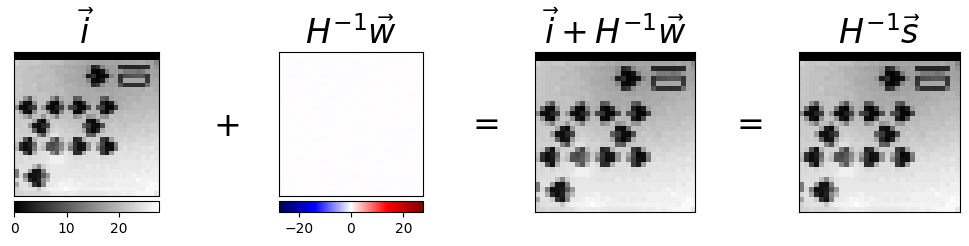

In [9]:
# Plot the thing with the image + the noise image = total image.

#########################
# CHANGE THIS VARIABLE: #
scale_factor = 1000
#########################


############# Dont change anything below ###################
# Load the image
i2D = np.load("scripts/raw_card.npy")
M, N = i2D.shape

# define the mask matrix
H = scale_factor * np.eye(M * N)

# Generate a noise vector
sigma = 1.25
noise = np.random.normal(0, sigma, H.shape[0])
noise = np.reshape(noise, (M, N))

# assemble noisy measurement
s = H.dot(i2D.ravel()).reshape((M, N)) + noise
recovered_image = np.linalg.inv(H).dot(s.ravel()).reshape((M, N))

# Plot the image, noise, and image with noise
plot_image_noise_visualization(i2D, noise, s, H)

**<span style="color:red">Which scaling factor performs better: 0.01 or 1000? Why?</span>**


**<span style="color:red">`1000`</span>**


### <a id = 'comparingScanning'><span style = "color: blue">Comparing Scanning Matrices</span></a>
Now let's take a look at the two matrices we will use to scan, hadamardH and randomH. The block of code below will show the ideal recovered image, along with the noise that gets added on top, and the total result. We will take care of generating the noise--all you have to do is tell us how much noise to add (by setting the `noise_magnitude` variable). In addition to displaying the images, the code will also print out the norm of the modified noise vector $H^{-1}\vec{\omega}$ so you can see quantitatively how different matrices impact the noise.

[comment]: <> (**<span style="color:red">First, just run the next code block so that you'll have access to `simulateCaptureWithNoise` below.</span>**)
**<span style="color:red">You will simulate the imaging system with different amounts of noise added. Run the code block below and change the noise magnitude to see how the output is affected.</span>**


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


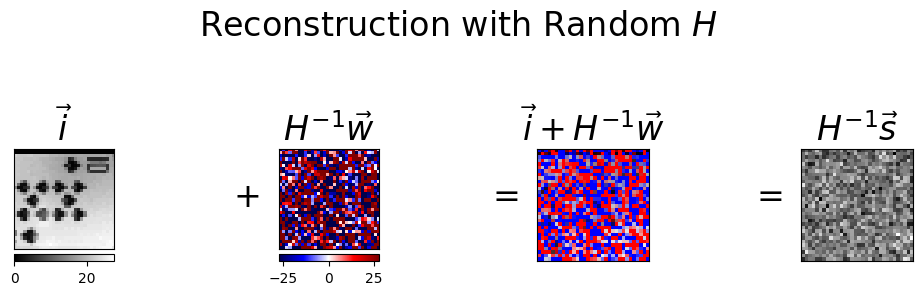

Norm of Hinv*w = 1585.4848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


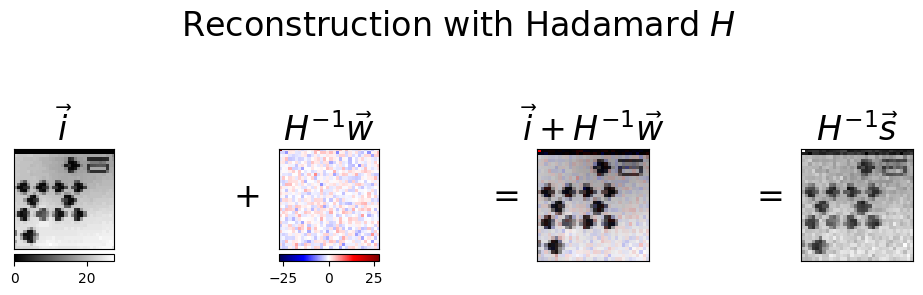

Norm of Hinv*w = 69.8312


In [10]:
##### Change this #######
noise_magnitude = 1000
#########################

############# Dont change anything below ###################
# Load the image
i2D = np.load("scripts/raw_card.npy")
M, N = i2D.shape

# define the mask matrix
randomH = generateRandomBinaryMask(avg1sPerRow=300, plot=False)
hadamardH = createHadamardMatrix(shape=randomH.shape, plot=False)

# Generate a noise vector
sigma = noise_magnitude / np.sqrt(M * N)  # noise magnitude --> std dev
noise = np.random.normal(0, sigma, randomH.shape[0])
noise = np.reshape(noise, (M, N))

# Plot the image, noise, and image with noise
plot_image_noise_visualization(
    i2D, noise, s, randomH, title="Reconstruction with Random $H$"
)
modified_noise_norm = np.linalg.norm(np.linalg.inv(randomH).dot(noise.ravel()))
print("Norm of Hinv*w = %0.4f" % (modified_noise_norm))

plot_image_noise_visualization(
    i2D, noise, s, hadamardH, title="Reconstruction with Hadamard $H$"
)
modified_noise_norm = np.linalg.norm(np.linalg.inv(hadamardH).dot(noise.ravel()))
print("Norm of Hinv*w = %0.4f" % (modified_noise_norm))

**<span style="color:red">What noise magnitudes did you have to use for each matrix to make the image borderline unrecognizable?</span>**

**<span style="color:red">`1000 +`</span>**

For this next section, we will examine the Hadamard matrix in a bit more detail. We will use the function `eigenanalysisComparison` that plots a histogram of the magnitudes of the eigenvalues of your $H$'s and their respective inverses (x axis = magnitude bins, y axis = number of eigenvalues within the bin's magnitude range). 

In [11]:
import numpy as np
import matplotlib.pyplot as plt

%run scripts/helpers.py
%matplotlib inline

<Figure size 640x480 with 0 Axes>

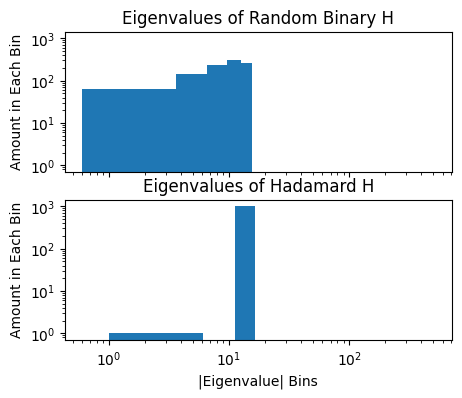

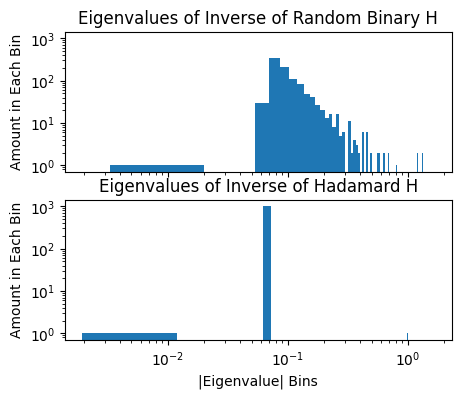

In [12]:
# Plot the eigenvalues of both H and hadamardH
eigenAnalysisComparison(
    H1=randomH, matrixName1="Random Binary H", H2=hadamardH, matrixName2="Hadamard H"
)

randomHInv = np.linalg.inv(randomH)
hadamardHInv = np.linalg.inv(hadamardH)

# Plot the eigenvalues of both the inverse of H and the inverse of hadamardH
eigenAnalysisComparison(
    H1=randomHInv,
    matrixName1="Inverse of Random Binary H",
    H2=hadamardHInv,
    matrixName2="Inverse of Hadamard H",
)

**<span style="color:red">Which of the two matrices `randomH` and `hadamardH` do you think is more noise robust and would result in a better reconstruction? Justify your answer using the eigenvalue histograms above.</span>**

**<span style="color:red">`hadamard as there are less amounts per average`</span>**

<a id='scanningImages'></a>
# <span style="color:blue">Task 3: Scanning Images</span>

In [13]:
np.save("saved_data/randomH.npy", randomH)
np.save("saved_data/hadamardH.npy", hadamardH)

**<span style="color:red">Before moving onto real imaging, please check that the the following files exist in your lab directory:</span>**

* **randomH.npy** - Saved `randomH` for restoring in case you have to close out of your Jupyter notebook. 
* **hadamardH.npy** - Saved `hadamardH` for restoring in case you have to close out of your Jupyter notebook.

<a id='softSetup'></a>
## <span style = "color: blue">Task 3a: Software Setup</span>

Now, we need an object to simulate taking a picture of. You can use an image of your choice for this lab (or stick with the one we've provided :). We suggest using one that has a single object with a simple, light background; say your favorite logo/emoji/animal. 

Simply download one (using Google Images for example) or click a picture and store it in an easily accessible place on your computer. We also suggest using .jpg or .jpeg file formats (feel free to convert .png files to these formats).

This lab is designed to work with 32x32 images. We have provided a resizing script to make sure that your image works with the simulator. However, selecting a high-resolution / detailed image may lead to a possible unrecognizable resized image as 32x32px images have comparatively low resolution.

1. Open the JupyterHub directory view (tab on the left of the notebook) and hit the `Upload` button.

<br>
<center><img src="images/upload_image_new_1.png" align="center"/ width="1279" height="761">

<left>2. Navigate to your image in the pop-out window, select it and click on "Open".
    
<br>    
<center><img src="images/upload_image_new_2.png" align="center"/ width="1218" height="720">  

<left>3. Click the `Upload` button next to the image selected.
    
<br>    
<center><img src="images/upload_image_new_3.png" align="center"/ width="1218" height="720"> 

<left>4. You should see the image in the `eecs16a_imaging_lab2_fa20` folder. 
    
<br>    
<center><img src="images/upload_image_new_4.png" align="center"/ width="1218" height="720"> 

This lab is designed to work with 32x32 images. `imageResize()` takes your (higher quality) image, picks the center portion of it, and reduces its quality to fit the desired size.

Set `uploadPath` to the name of the image you've chosen (with its extension, for example "picture.jpg") and set `imagePath` to the path you want the resized imaged to have  (with its extension, for example "picture.jpg"). 

**Note: Passing in a path to a high-resolution / detailed image may lead to a badly resized image as 32x32px images have comparatively low resolution. The new image might be unrecognizable.**

In [14]:
# Image Resize
height, width = 32, 32
uploadPath = "eecs16a.jpg"  # TODO: replace with your uploaded image file path
imagePath = "eecs16a32x32.jpg"  # TODO: replace with the filename for your resized image
imageResize(uploadPath, imagePath, height, width)

<a id='singlePixel'></a>
## <span style="color:blue">Task 3b: Single Pixel Sanity Check</span>

When dealing with a complicated system, it is often useful to perform a "sanity check" to make sure that a simpler subset of the system is working as expected, before adding more complexity. As a reminder, let's review masking matrices from single pixel imaging in the last lab before extending what we know to multipixel imaging. 

**<span style="color:red">Create $H_{Single}$ for images/masks with dimensions 32x32. How many rows should it have? Note that $H_{Single}$ is the identity matrix.</span>**

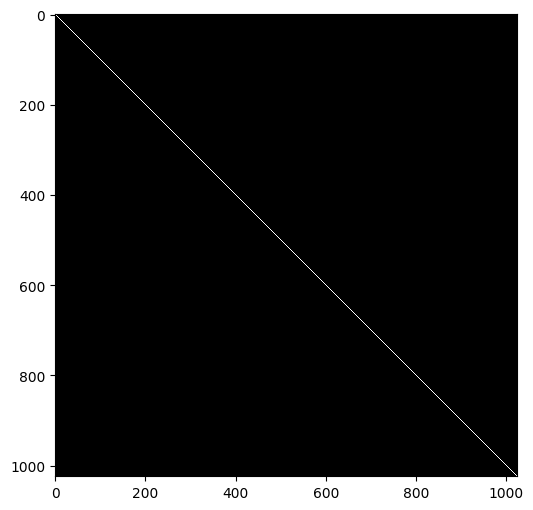

In [15]:
# TODO: Recreate `HSingle` to scan a 32x32 image. `HSingle` is the identity matrix.
height = 32
width = 32
HSingle = np.eye(height * width)  # YOUR CODE HERE

plt.figure(figsize=(6, 6))
plt.imshow(HSingle, cmap="gray", interpolation="nearest")
np.save("saved_data/HSingle.npy", HSingle)

**<span style="color:red">You will then run the `masking_simulation.py` script below that projects mask patterns onto your image based on the $H$ matrix that you designed. </span>**  This script controls the scanning process. 

<!--The following cell runs `cumulative_imaging_simulation.py` which will display the sensor vector reshaped to the original image's dimensions.-->

The commands in the code block below use the following tags: 
- `--mask`: points to the file (with its extension, for example "matrix.npy") associated with the mask matrix you want to use 
- `--width`, `--height`: dimensions of the image being scanned
- `--image`: specifies the path to the image being scanned (with its extension, for example "picture.jpg")
- `--overlay` (**`masking_simulation.py`** only): see each mask overlaid on the image. It is set to True by default. 

When running **`masking_simulation.py`**, a popup widget will appear, depicting the masks being applied to the image during each scan. The call to `simulateRealImaging` directly below this will save the resulting sensor vector to the file specified by sensorFilename. 

<!--When **`cumulative_imaging_simulation.py`** begins running, the centered popup widget will go through the captured brightness values collected so far as the number of scans increases.-->

`masking_simulation.py` iterates over the rows of the $H$ matrix you made. These rows are translated, one-by-one, into real masks projected onto the screen. Sensor readings are taken for each mask. At the start of the scan, you'll see a series of `Count: # Brightness value: #` printed to the output below. `Count` corresponds to the index $k$ of the current sensor reading (and likewise current row of H). `Brightness` corresponds to the digitized value obtained from imaging using the given mask. This "debug" information is printed consecutively for the first few sensor outputs. Otherwise, this info is printed when `k % 100 = 0` (every 100 scans).

We **DO NOT** run `cumulative_imaging_simulation.py` in this lab because seeing the sensor output vector being built element-wise is not particularly useful to study noise in the imaging system.

*Note: In a real-world projector setup (**not in this virtual arrangement**), scanning would take much longer (a few minutes) because:*
* We average sensor readings to improve the signal-to-noise ratio. Therefore we need to read more times.
* As you'll learn in Module 2, capacitors take some time to charge and discharge. A capacitor acts as a "low-pass filter." We used a 0.1$\mu$F capacitor in our sensing circuit to "smooth" the output and suppress "high-frequency" noise. In order to give the capacitor time to "settle" (i.e. ~fully charge/discharge), we need to wait longer between scans. Otherwise, the sensor reading will also include some "memory" of the previous scan result, when we really want the reading to only be about the current scan. 

In [16]:
# Import necessary libraries (so you don't have to start from the top)
import numpy as np
import matplotlib.pyplot as plt

%run scripts/helpers.py
%matplotlib inline

<Figure size 640x480 with 0 Axes>

**<span style="color:red">Recreate the image from the sensor readings obtained with `HSingle`  in the following code blocks as a reminder of what you worked on in Imaging 2.</span>**

In [17]:
##### Change this #######
noise_magnitude = (
    300  # you can play around with this noise parameter in the range [0, +infinity)
)
#########################
height = 32
width = 32
# Parameter used to generate noise vector
sigma = noise_magnitude / np.sqrt(height * width)  # noise magnitude --> std dev

**<span style="color:red ; font-size: 20px">Please click on this <a href="https://eecs.datahub.berkeley.edu/hub/user-redirect/desktop">link</a> before proceeding any further. It will open another browser tab where the visuals will be visible. Login with your CalNet ID, if prompted. If you see a pop-up in the middle of your screen, click on `Use Default Config`. Then return back to this notebook tab.</span>**

In [18]:
# Imaging
HSingle = np.load("saved_data/HSingle.npy")
sensorFilename = "saved_data/s_single_vec"

# As soon as you run this block, please open the browser tab with the visuals.
# Once the single visual has finished executing, please return to this notebook tab.

%run scripts/masking_simulation.py --width 32 --height 32 --mask "saved_data/HSingle.npy" --image $imagePath --sleepTime 10
simulateRealImaging(imagePath, HSingle, "HSingle", sensorFilename, sigma)

/Users/briancpark/My Drive/UC BERKELEY/SEMESTERS/FALL 2020/EECS 16A/CODE/labs/eecs16a_imaging_lab3_fa20/scripts/masking_simulation.py:5: DeprecationWarning: Support for PyQt5 is deprecated and will be removed in Pillow 10 (2023-07-01). Use PyQt6 or PySide6 instead.
  from PIL import ImageQt



EECS16A Imaging Lab

Sleep time in ms: 10
Image width: 32
Image height: 32
Mask file: saved_data/HSingle.npy 

Image file: eecs16a32x32.jpg 

Overlay enabled: True 

Count: 0, Brightness value: 255

Count: 1, Brightness value: 236

Count: 2, Brightness value: 255

Count: 3, Brightness value: 255

Count: 4, Brightness value: 243

Count: 5, Brightness value: 255

Count: 6, Brightness value: 255

Count: 7, Brightness value: 251

Count: 8, Brightness value: 253

Count: 9, Brightness value: 253

Count: 10, Brightness value: 255

Count: 100, Brightness value: 250

Count: 200, Brightness value: 220

Count: 300, Brightness value: 223

Count: 400, Brightness value: 255

Count: 500, Brightness value: 249

Count: 600, Brightness value: 250

Count: 700, Brightness value: 226

Count: 800, Brightness value: 255

Count: 900, Brightness value: 247

Count: 1000, Brightness value: 244


Scan completed
Scan time: 0.000 m  10.371 s


Text(0.5, 1.0, 'Sensor Reading, Using HSingle')

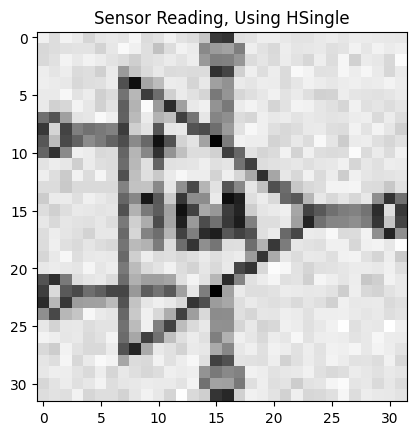

In [19]:
# Sensor readings
srSingle = np.load(sensorFilename + ".npy")

plt.imshow(np.reshape(srSingle, (width, height)), cmap="gray", interpolation="nearest")
plt.title("Sensor Reading, Using HSingle")

Text(0.5, 1.0, 'Ideal Reconstruction, Using HSingle')

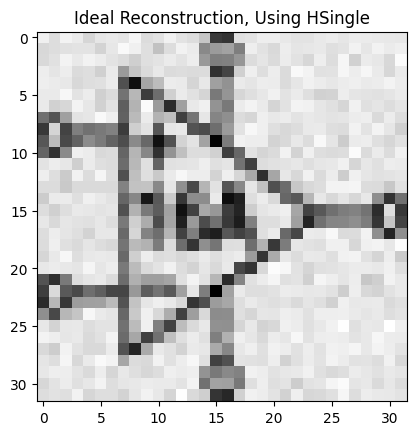

In [20]:
# TODO: Create the image vector from `HSingle` and `srSingle`
# Hint: Because `HSingle` is a special matrix, technically you do not need to perform any matrix operations
ivSingle = HSingle @ srSingle  # YOUR CODE HERE

img = np.reshape(ivSingle, (height, width))
plt.imshow(img, cmap="gray", interpolation="nearest")
plt.title("Ideal Reconstruction, Using HSingle")

## <a id ='realImaging'><span style = "color: blue">Task 3c: Real Multipixel Imaging</span></a>

In the previous section, we scanned our image one pixel at a time. Now we are going to use the two matrices you examined earlier to scan. Run the following blocks to scan your image with each of the two matrices **`randomH`** and **`hadamardH`**.

In [21]:
%run scripts/helpers.py
%matplotlib inline

# Imaging
randomH = np.load("saved_data/randomH.npy")
sensorFilename = "saved_data/s_vec"

# As soon as you run this block, please open the browser tab with the visuals.
# Once the single visual has finished executing, please return to this notebook tab.

%run scripts/masking_simulation.py --width 32 --height 32 --mask "saved_data/randomH.npy" --image $imagePath --sleepTime 10
simulateRealImaging(imagePath, randomH, "randomH", sensorFilename, sigma)


EECS16A Imaging Lab

Sleep time in ms: 10
Image width: 32
Image height: 32
Mask file: saved_data/randomH.npy 

Image file: eecs16a32x32.jpg 

Overlay enabled: True 

Count: 0, Brightness value: 61650

Count: 1, Brightness value: 61877

Count: 2, Brightness value: 64662

Count: 3, Brightness value: 58817

Count: 4, Brightness value: 65453

Count: 5, Brightness value: 60546

Count: 6, Brightness value: 65489

Count: 7, Brightness value: 64415

Count: 8, Brightness value: 62865

Count: 9, Brightness value: 69924

Count: 10, Brightness value: 63448

Count: 100, Brightness value: 70338

Count: 200, Brightness value: 67388

Count: 300, Brightness value: 61006

Count: 400, Brightness value: 64895

Count: 500, Brightness value: 63253

Count: 600, Brightness value: 68748

Count: 700, Brightness value: 63287

Count: 800, Brightness value: 61118

Count: 900, Brightness value: 62234

Count: 1000, Brightness value: 64260


Scan completed
Scan time: 0.000 m  10.282 s


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Sensor Reading, Using randomH')

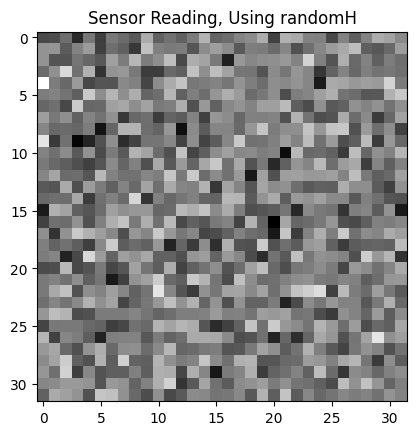

In [22]:
# Sensor readings
sr = np.load(sensorFilename + ".npy")

plt.imshow(np.reshape(sr, (width, height)), cmap="gray", interpolation="nearest")
plt.title("Sensor Reading, Using randomH")

**<span style="color:red">Let's reconstruct your image. Based off of your simulation results, is this the reconstruction quality that you expected using `H`? Think about how noisy our actual imaging system is.</span>**

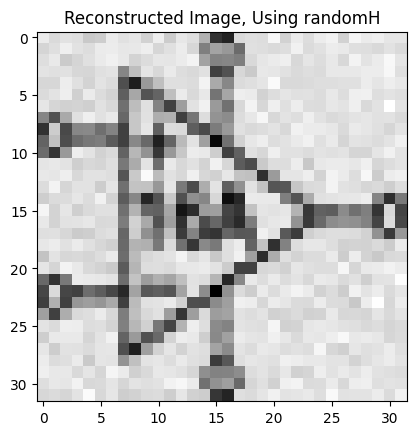

In [23]:
idealReconstruction(H=randomH, matrixName="randomH", s=sr)

`Yes, as our sensor is noisy`

**As expected, the randomly generated H matrix does not work well, if at all.** Remember that randomH generally has small eigenvalues (less than 1), which we don't want.

Next, let's try to imaging with `hadamardH`. 

**<span style="color:red">Run the following code block. It will simulate the process of capturing sensor readings using the Hadamard matrix `hadamardH`.</span>**

In [24]:
%run scripts/helpers.py
%matplotlib inline

# Imaging
hadamardH = np.load("saved_data/hadamardH.npy")
sensorFilename = "saved_data/s_hadamard_vec"

# As soon as you run this block, please open the browser tab with the visuals.
# Once the single visual has finished executing, please return to this notebook tab.

%run scripts/masking_simulation.py --width 32 --height 32 --mask "saved_data/hadamardH.npy" --image $imagePath --sleepTime 10
simulateRealImaging(imagePath, hadamardH, "hadamardH", sensorFilename, sigma)


EECS16A Imaging Lab

Sleep time in ms: 10
Image width: 32
Image height: 32
Mask file: saved_data/hadamardH.npy 

Image file: eecs16a32x32.jpg 

Overlay enabled: True 

Count: 0, Brightness value: 225214

Count: 1, Brightness value: 112934

Count: 2, Brightness value: 113029

Count: 3, Brightness value: 110503

Count: 4, Brightness value: 111832

Count: 5, Brightness value: 108466

Count: 6, Brightness value: 108287

Count: 7, Brightness value: 114879

Count: 8, Brightness value: 112361

Count: 9, Brightness value: 112571

Count: 10, Brightness value: 110814

Count: 100, Brightness value: 112929

Count: 200, Brightness value: 114216

Count: 300, Brightness value: 113926

Count: 400, Brightness value: 119119

Count: 500, Brightness value: 112106

Count: 600, Brightness value: 111681

Count: 700, Brightness value: 112470

Count: 800, Brightness value: 112888

Count: 900, Brightness value: 112470

Count: 1000, Brightness value: 112906


Scan completed
Scan time: 0.000 m  10.256 s


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Sensor Reading, Using hadamardH')

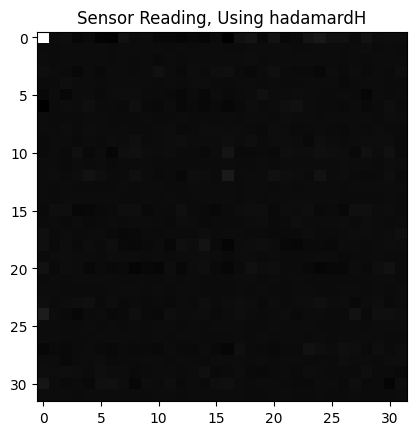

In [25]:
# Sensor readings
sr = np.load(sensorFilename + ".npy")

plt.imshow(np.reshape(sr, (width, height)), cmap="gray", interpolation="nearest")
plt.title("Sensor Reading, Using hadamardH")

<span >Don't worry if your sensor output "looks" incorrect. hadamardH is different from other matrices we've used before. We must reconstruct the image to check correctness. </span>

**<span style="color:red">Let's reconstruct your image. Based off of your simulation results, is this the reconstruction quality that you expected using `hadamardH`?</span>**

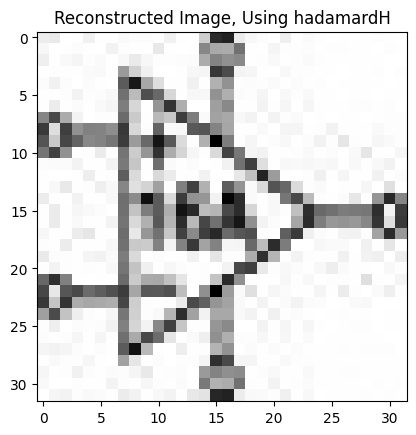

In [26]:
idealReconstruction(H=hadamardH, matrixName="hadamardH", s=sr)

**`Yes`**

**<span style="color:red">Comment on your reconstruction results when using `randomH` and `hadamardH`. In real imaging, which matrix did better? Did this match your expectations from simulation? Why? How did you expect multipixel imaging to compare to single pixel imaging from Imaging 2? What are some observed limitations of multipixel imaging?</span>**

<span style="color:red">**`Hadamard did much better`**</span>

<a id='checkoff'></a>
## Checkoff
When you are ready to get checked off,
1. Fill out the checkoff google form. **[Checkoff Form](https://forms.gle/5W8u2thJzsmWLDsa9)**
2. Submit a **checkoff** request on the lab queue. **[Checkoff queue](https://lab.eecs16a.org)** It is fine if only one person from your group submits the lab queue request, but everyone must submit their own google form. 

Your GSI or a Lab Assistant will join your breakout room when they are available and go through some checkoff questions with your group. They will go through the checkoff list in order. Please be patient!

## **<span style="color:red"> Please have your notebook ready to demo before being checked off. </span>**

### Buffer Sign Up
In case you have **<span style="color:red">missed</span>** any one of Imaging 1, Imaging 2 or Imaging 3, please fill out the following google form to sign up for a buffer lab.
<br>
**[Buffer Sign Up Form](https://forms.gle/rwdN2b4knseQDqC5A)**